In [10]:


# List of specific mission types interested in
mission_types = [17, 19, 271, 8201, 8416, 8420, 20, 14, 22, 64, 280, 8412, 8440]

# Initialize a dictionary to hold routes for each mission
all_routes = {}
all_filtered_rows = []  # List to store rows used to generate the routes

# Loop through each mission type
for mission_type in mission_types:
    # Initialize a list to hold the routes for the current mission
    routes = []

    # Step 4: Iterate through the DataFrame to build routes
    for index, row in filtered_for_date.iterrows():
        if row['UppehållstypAvgång'] == 'Första' and row['Tåguppdrag'] == mission_type:
            # Start the route with the departure station
            current_route = [row['Avgångsplats']]
            all_filtered_rows.append(row)  # Save the current row to the list
            next_row = row

            # Continue to add stations until reaching 'Sista'
            while next_row['UppehållstypAnkomst'] != 'Sista':
                # Find the next station in the DataFrame that matches the current departure station
                next_station = filtered_for_date[(filtered_for_date['Avgångsplats'] == next_row['Ankomstplats']) &
                                  (filtered_for_date['Tåguppdrag'] == mission_type)]

                if not next_station.empty:
                    current_route.append(next_station.iloc[0]['Ankomstplats'])
                    all_filtered_rows.append(next_station.iloc[0])  # Save the row to the list
                    next_row = next_station.iloc[0]  # Move to the next row
                else:
                    break  # Exit if no further stations are found

            # If the last station is 'Sista', append it to the route
            if next_row['UppehållstypAnkomst'] == 'Sista':
                current_route.append(next_row['Ankomstplats'])

            # Add the complete route to the routes list
            routes.append(" -> ".join(current_route))

    # Store the routes for the current mission in the dictionary
    all_routes[mission_type] = routes

# Save the filtered rows used to generate the routes into a new DataFrame
filtered_rows_df = pd.DataFrame(all_filtered_rows)



In [36]:
def missing_utfAvgTid(df):
    missing_rows_Avg = df[df['UtfAvgTid'].isnull()] 
    missing_rows_Ank = df[df['UtfAnkTid'].isnull()]
    #this Avg station should be the same as the previous Ank station
    for row in missing_rows_Avg.iterrows():
        row = row[1]
    
        train_number = row['Tåguppdrag']
        date = row['Datum_PAU']
        previous_station = df[(df['Tåguppdrag'] == train_number) & (df['Datum_PAU'] == date) & (df['Ankomstplats'] == row['Avgångsplats'])]
        if previous_station.empty:
            print('No previous station found for', train_number, date, row['Avgångsplats'])
        else:
            #update the row where id is the same as the missing row
            row_id = row['id']
            df.loc[df['id'] == row_id, 'UtfAvgTid'] = previous_station['UtfAnkTid'].values[0]
    
    for row in missing_rows_Ank.iterrows():
        train_number = row['Tåguppdrag']
        date = row['Datum_PAU']
        next_station = df[(df['Tåguppdrag'] == train_number) & (df['Datum_PAU'] == date) & (df['Avgångsplats'] == row['Ankomstplats'])]
        if next_station.empty:
            print('No next station found for', train_number, date, row['Ankomstplats'])
        else:
            #update the row where id is the same as the missing row
            row_id = row['id']
            df.loc[df['id'] == row_id, 'UtfAnkTid'] = next_station['UtfAvgTid'].values[0]
    print('\n------Missing values filled------')
    print("total missing values in UtfAvgTid", len(missing_rows_Avg))
    print("total missing values in UtfAnkTid", len(missing_rows_Ank))
    print("after update total nan avg values are ", len(df[df['UtfAvgTid'].isnull()]))
    print("after update total nan ank values are ", len(df[df['UtfAnkTid'].isnull()]))
    print("\n\n\n")
    return

def create_ids(df):
    #create a unique id for each row
    df['id'] = df.index
    return

In [37]:

create_ids(filtered_rows_df)
missing_utfAvgTid(filtered_rows_df)




------Missing values filled------
total missing values in UtfAvgTid 0
total missing values in UtfAnkTid 0
after update total nan avg values are  0
after update total nan ank values are  0






In [38]:


# Save the DataFrame to a CSV file
output_rows_file_name = 'rows_used_for_routes.csv'
filtered_rows_df.to_csv('data/' + output_rows_file_name, index=False, encoding='utf-8-sig')



# Display the routes for each mission
for mission, routes in all_routes.items():
    print(f"\nRoutes for {mission}:")
    for route in routes:
        print("Route:", route)

# Notify the user where the rows have been saved
print(f"\nThe rows used to generate the routes have been saved to {output_rows_file_name}")




Routes for 17:
Route: Falun -> Ornäs -> Borlänge c -> Stora Tuna -> Gustafs -> Säter -> Vikmanshyttan -> Hedemora -> Snickarbo -> Avesta Centrum -> Avesta Krylbo -> Rosshyttan -> Broddbo -> Sala -> Isätra -> Heby -> Morgongåva -> Järlåsa -> Brunna -> Uppsala norra -> Uppsala c -> Säby -> Ekeby -> Knivsta -> Myrbacken -> Arlanda Central -> Arlanda nedre -> Blackvreten -> Skavstaby -> Upplands Väsby -> Rotebro -> Norrviken -> Häggvik -> Sollentuna -> Kummelby -> Helenelund -> Ulriksdal -> Solna -> Tomteboda övre -> Karlberg -> Stockholm C -> Stockholm C

Routes for 19:
Route: Falun -> Ornäs -> Borlänge c -> Stora Tuna -> Gustafs -> Säter -> Vikmanshyttan -> Hedemora -> Snickarbo -> Avesta Centrum -> Avesta Krylbo -> Rosshyttan -> Broddbo -> Sala -> Isätra -> Heby -> Morgongåva -> Järlåsa -> Brunna -> Uppsala norra -> Uppsala c -> Säby -> Ekeby -> Knivsta -> Myrbacken -> Arlanda Central -> Arlanda nedre -> Blackvreten -> Skavstaby -> Upplands Väsby -> Rotebro -> Norrviken -> Häggvik -> S

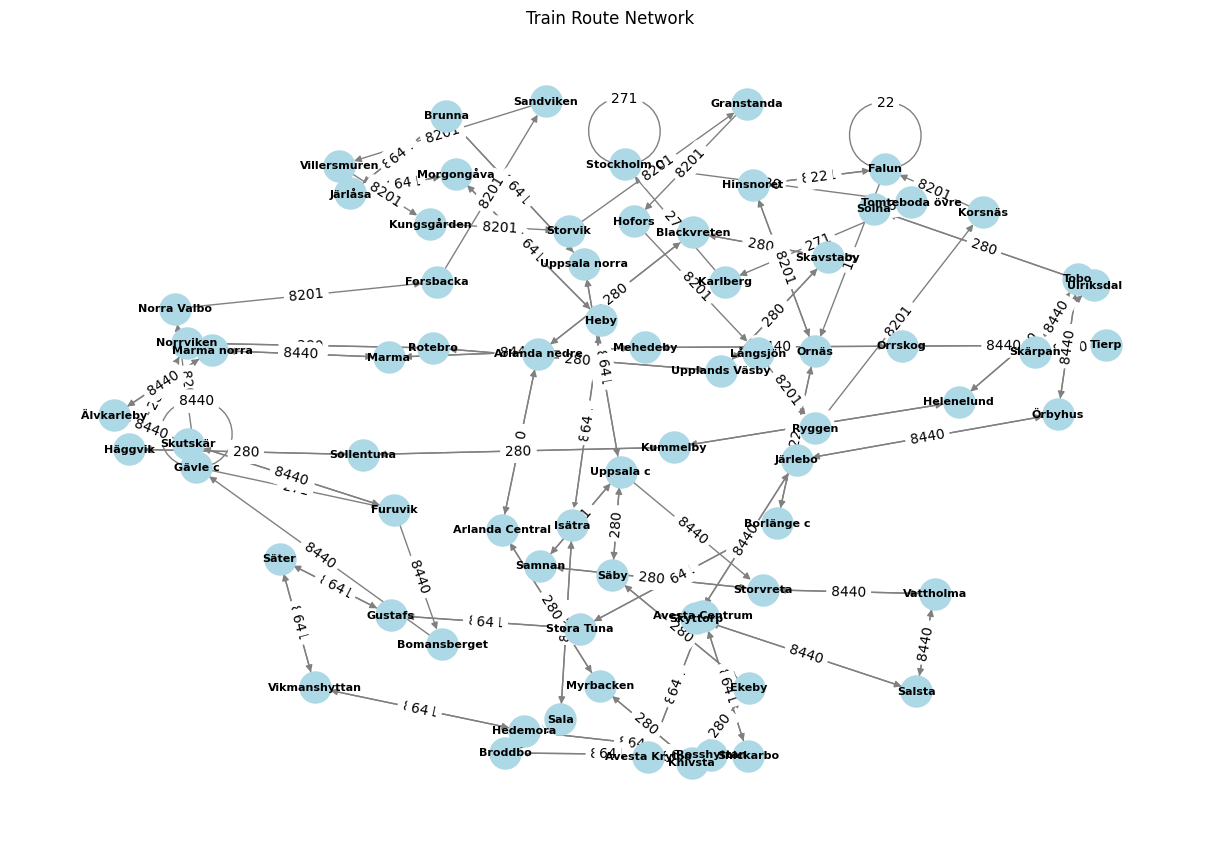

In [89]:
import networkx as nx

G = nx.DiGraph()

# Add edges for each route
for mission, routes in all_routes.items():
    for route in routes:
        stations = route.split(" -> ")
        for i in range(len(stations) - 1):
            G.add_edge(stations[i], stations[i + 1], mission=mission)

# Draw the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=0.5)  # positions for all nodes
nx.draw(G, pos, with_labels=True, node_size=500, node_color="lightblue", font_size=8, font_weight="bold", edge_color="gray", arrows=True)

# Show edge labels for mission types
edge_labels = nx.get_edge_attributes(G, 'mission')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.title("Train Route Network")
plt.show()
